In [ ]:
## https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/

In [1]:
from langgraph.graph import Graph

# define a langchain graph
graph_builder = Graph()

In [2]:
# lets first understand how the Graph things work here
# nodes act like functions that can be called as needed
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("node_1", function_1)
graph_builder.add_node("node_2", function_2)

In [3]:
graph_builder.add_edge("node_1", "node_2")
graph_builder.set_entry_point("node_1")
graph_builder.set_finish_point("node_2")

In [4]:
graph = graph_builder.compile()

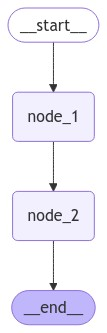

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# now, lets run the chatbot
graph.invoke("Hello")

'Hello Hi there'

In [ ]:
#Let's build a basic chatbot
#LangSmith -> Debug, collaborate, test, and monitor your LLM applications.

In [7]:
# langsmith makes it esier to see what's going on "under the hood"
# https://eu.smith.langchain.com
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
langchain api## <LANGCHAIN_API_KEY>

In [18]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"] = "https://us.api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-tutorial"

In [19]:
from langchain_openai import ChatOpenAI

In [57]:
llm_local = ChatOpenAI(api_key="<LANGCHAIN_API_KEY>",model="llama3.1:8b",base_url="http://localhost:11434/v1",)

In [58]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [59]:
def chatbot(state: State):
    return {"messages": [llm_local.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [60]:
# Next, add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

In [61]:
# Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

In [62]:
# Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. 
# This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()


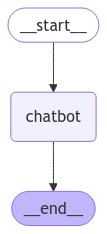

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
# now, lets run the chatbot
# Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

while True:  # Start an infinite loop to keep the program running until a break condition is met.
    user_input = input("User: ")  # Prompt the user to input a message.
    
    # Check if the user wants to quit by typing "quit", "exit", or "q" (case-insensitive).
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a goodbye message.
        break  # Exit the loop and end the program.
    
    # Stream events from the 'graph' using the user input, processing each event returned.
    for event in graph.stream({"messages": ("user", user_input)}):
        # Iterate over each value in the event.
        for value in event.values():
            # Print the assistant's response, which is the last message in the 'messages' list of the value.
            print("Assistant:", value["messages"][-1].content)

User:  hello


Assistant: Hello! How are you today?


User:  quit


Goodbye!


In [65]:
llm_local.invoke("hello world!")

AIMessage(content='Hello World! Nice to meet you! Is there something I can help you with, or would you like to just say hello and see where the conversation goes?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 13, 'total_tokens': 46, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.1:8b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-05fa2b11-c36a-44e4-8293-5ba20222cccc-0', usage_metadata={'input_tokens': 13, 'output_tokens': 33, 'total_tokens': 46, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
TAVILY API: <TAVILY_API_KEY>

In [ ]:
##Enhancing the Chatbot with Tools ( web search tool )

In [40]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [66]:
# lets define the tool

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [67]:
tool.invoke("What is the weather of Helsinki in Celsius?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Helsinki', 'region': 'Southern Finland', 'country': 'Finland', 'lat': 60.176, 'lon': 24.934, 'tz_id': 'Europe/Helsinki', 'localtime_epoch': 1728257413, 'localtime': '2024-10-07 02:30'}, 'current': {'last_updated_epoch': 1728256500, 'last_updated': '2024-10-07 02:15', 'temp_c': 8.1, 'temp_f': 46.6, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 8.1, 'wind_kph': 13.0, 'wind_degree': 257, 'wind_dir': 'WSW', 'pressure_mb': 1010.0, 'pressure_in': 29.83, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 93, 'cloud': 0, 'feelslike_c': 5.9, 'feelslike_f': 42.5, 'windchill_c': 7.4, 'windchill_f': 45.4, 'heatindex_c': 9.4, 'heatindex_f': 48.9, 'dewpoint_c': 7.0, 'dewpoint_f': 44.5, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 1.0, 'gust_mph': 15.0, 'gust_kph': 24.1}}"},
 {'url': 'https://www.timeanddate.com/weather/finland/helsinki/ext',
  'con

In [68]:
llm_with_tools = llm_local.bind_tools(tools)

In [69]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

#llm = ChatOpenAI(temperature=0, streaming=True)
#llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm_local.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [70]:
#Create a function to actually run the tools if they are called

In [71]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A class representing a node that processes and executes tool requests embedded in the last AI message."""

    def __init__(self, tools: list) -> None:
        """
        Initializes the BasicToolNode with a list of available tools.
        
        Args:
            tools (list): A list of tool objects that the node can use to execute requests.
        """
        # Creates a dictionary mapping tool names to tool objects for quick lookup during execution
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Processes the input data to extract the latest message and execute the requested tools.
        
        Args:
            inputs (dict): A dictionary containing messages, where each message can contain tool calls.
        
        Returns:
            dict: A dictionary with a list of ToolMessage objects containing the results of tool executions.
        
        Raises:
            ValueError: If no messages are found in the input.
        """
        # Extracts the latest message from the input, raising an error if no messages are found
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # List to accumulate the outputs of each tool invocation
        outputs = []
        
        # Iterate over each tool call in the message, invoking the corresponding tool and collecting the results
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Wraps the tool result in a ToolMessage object and appends it to the outputs list
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        
        # Returns a dictionary with the key "messages" containing the list of ToolMessage objects
        return {"messages": outputs}

# Example usage: Instantiating the BasicToolNode with a list of tools and adding it to a graph builder
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [72]:
#Now, lets define the conditional edges

In [73]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Determines the next node in the processing graph based on the last AI message in the state.
    
    This function is used in a conditional edge to decide whether to route the flow to the 'tools' node,
    if the last message contains tool calls, or to the '__end__' node if no tool calls are present.

    Args:
        state (State): The current state, which may be a list of messages or a dictionary containing messages.
    
    Returns:
        Literal["tools", "__end__"]: A string indicating the next node to route to. Returns "tools" if the last 
        message has tool calls, otherwise returns "__end__".
    
    Raises:
        ValueError: If no messages are found in the state.
    """
    # Checks if the state is a list, retrieves the last message; otherwise, tries to get it from a dictionary
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # If the last message contains tool calls, route to the "tools" node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    # If no tool calls are found, route to the "__end__" node
    return "__end__"


# Conditional routing function to direct the flow based on the presence of tool calls in the last message
# The route_tools function will return "tools" if the AI message has tool calls, otherwise "__end__"
graph_builder.add_conditional_edges(
    "chatbot",  # The node from which the routing decision will be made
    route_tools,  # The function that determines the next node
    {
        # Mapping of function return values to specific nodes in the graph
        "tools": "tools",       # If the function returns "tools", route to the "tools" node
        "__end__": "__end__",   # If the function returns "__end__", route to the "__end__" node
    }
)

# Adding an edge to return to the chatbot node after any tool call to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Starting the graph by linking the START node to the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph to finalize the structure and prepare it for execution
graph = graph_builder.compile()

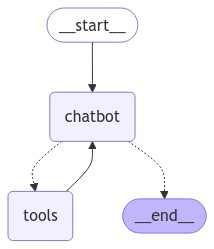

In [74]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import BaseMessage

# Start an infinite loop to continuously interact with the user
while True:
    # Prompt the user for input and capture their response
    user_input = input("User: ")
    
    # Check if the user wants to quit the interaction
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a farewell message
        break  # Exit the loop, ending the program
    
    # Stream events from the graph using the user's input
    # The input is wrapped in a dictionary with "messages" key containing a list of tuples (message type, content)
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Iterate over the values produced by each event in the stream
        for value in event.values():
            
            # Check if the last message in the list is an instance of BaseMessage
            if isinstance(value["messages"][-1], BaseMessage):
                
                # Print the content of the Assistant's response
                print("Assistant:", value["messages"][-1].content)

User:  I like red color


Assistant: 
Assistant: [{"url": "https://html-color.codes/red", "content": "Red Color Codes. The colors: upsdell red, red (ncs), jasper, medium candy apple red, redwood and fuzzy wuzzy are a few examples of red shades. See more named color codes similar to red below! See also: Red Color Hex Chart. A List of Red Shades. Red #ff0000 | rgb(255,0,0) Light ..."}, {"url": "https://www.colorsexplained.com/shades-of-red-color-names/", "content": "Learn about the meaning, facts, and uses of red color in design and branding. Browse a comprehensive list of 99 shades of red color with their hex, RGB, and CMYK codes."}]
Assistant: It seems you like the color red! Did you know that there are many different shades of red, such as upsdell red, jasper, medium candy apple red, and fuzzy wuzzy? You can also find a list of 99 shades of red color with their hex, RGB, and CMYK codes on websites like ColorsExplained.com.


User:  what is jasper shade of red


Assistant: 
Assistant: [{"url": "https://www.gemstonist.com/red-jasper/", "content": "Red Jasper has a brick-red color, but it also comes in a variety of other shades, ranging from brownish red to orangey red. The higher concentrations of other elements in the basic crystal of jasper result in different colors and varieties of jasper gemstone. The red hue of red jasper is due to high levels of Iron in the opaque and trigonal ..."}, {"url": "https://rockchasing.com/carnelian-vs-red-jasper/", "content": "Color - Red jasper has a deep red color. Polished red jaspers photo provided by and available for purchase at NewMoonBeginnings. With its diverse spectrum of colors, carnelian is often described as a fiery gem. You can find it in shades of vibrant orange, intense red, and even softer hues like pale peach and brownish-red. ..."}]
Assistant: The Jasper shade of red is typically a brick-red color with variations ranging from brownish red to orangey red due to high levels of Iron in the opaq

User:  For cancer immune therapy, how to target macrophage?


Assistant: 
Assistant: [{"url": "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7994399/", "content": "There are several advantages to target macrophages in cancer immunotherapy. Low infiltration is a major barrier for T-cell-based anticancer therapy, and macrophages account for ~30-50% of infiltrating immune cells in the tumor microenvironment."}, {"url": "https://www.nature.com/articles/s41392-021-00506-6", "content": "There are several advantages to target macrophages in cancer immunotherapy. Low infiltration is a major barrier for T-cell-based anticancer therapy, and macrophages account for ~30-50% of ..."}]
Assistant: Based on the search results, it appears that targeting macrophages in cancer immune therapy can be beneficial due to their presence in the tumor microenvironment. Macrophages can account for up to 50% of infiltrating immune cells, making them a potential target for immunotherapy.

Some possible ways to target macrophages in cancer immune therapy include:

*   Using the

User:  how to reprogram macrophage?


Assistant: 
Assistant: [{"url": "https://www.nature.com/articles/s41467-019-11911-5", "content": "MRNA-carrying nanoparticles encoding human IRF5/IKK\u03b2 reprogram human macrophages. a Time line and culture conditions to differentiate the human THP-1 monocytic cell line into suppressive M2-like ..."}, {"url": "https://www.sciencedirect.com/science/article/pii/S1043276024002443", "content": "Strategies that reprogram macrophage metabolism might inadvertently affect the metabolism of other cell types or tissues, leading to unintended consequences. There is a potential for target cells to adapt to metabolic reprogramming, leading to a loss of efficacy over time. In addition, given the variability in patient metabolism, personalized ..."}]
Assistant: Based on the tool call response, it appears that there are several ways to reprogram macrophages, including:

1. Using mRNA-carrying nanoparticles encoding human IRF5/IKKβ to reprogram human macrophages.
2. Strategies that target the metabol